In [63]:
from cmdstanpy import CmdStanModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Regime 1 has 82 days
Regime 2 has 78 days
Regime 3 has 129 days
Regime 4 has 133 days
Regime 5 has 82 days


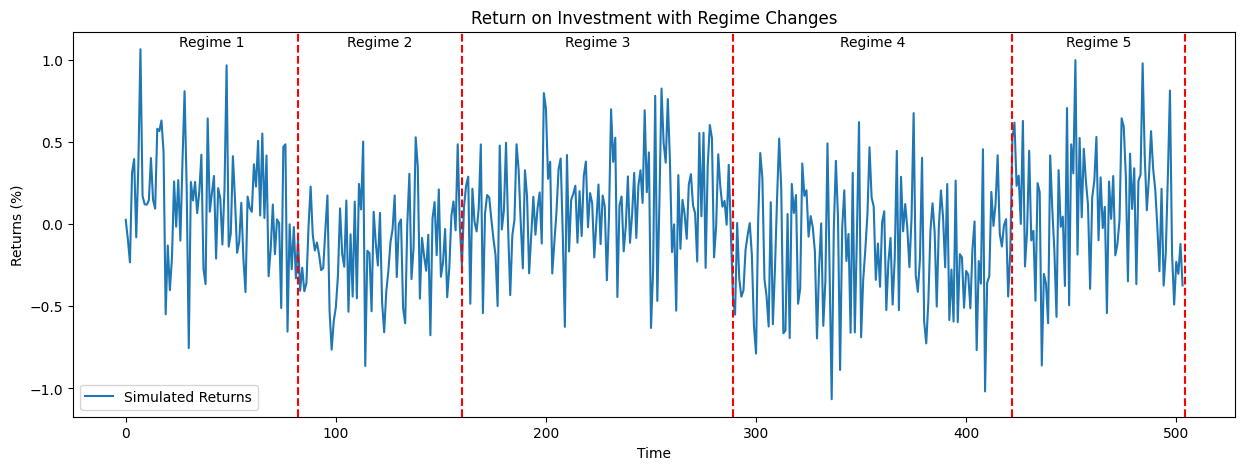

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from hmmlearn import hmm
# Parameters
num_regimes_changes = 5
min_days, max_days = 70, 150
bull_mean, bull_var = 0.1, 0.1
bear_mean, bear_var = -0.15, 0.1

days = [randint(min_days, max_days) for _ in range(num_regimes_changes)]
sim_data = []

for i in range(len(days)):
    if i % 2 == 0:
        sim_data.extend(np.random.normal(bull_mean, np.sqrt(bull_var), size=days[i])) 
    else:
        sim_data.extend(np.random.normal(bear_mean, np.sqrt(bear_var), size=days[i]))
sim_data = np.array(sim_data)

plt.figure(figsize=(15, 5))
plt.plot(sim_data, label='Simulated Returns')

day = 0
true_regimes = []
for i in range(len(days)):
    print(f"Regime {i+1} has {days[i]} days")
    true_regimes.extend([i+1] * days[i])
    day += days[i]
    plt.axvline(x=day, color='red', linestyle='--')
    # Optional: add text label
    plt.text(day - days[i]/2, max(sim_data), f'Regime {i+1}', horizontalalignment='center', verticalalignment='bottom')

plt.xlabel("Time")
plt.ylabel("Returns (%)")
plt.title('Return on Investment with Regime Changes')
plt.legend()
plt.show()


In [46]:
# Prepare data for hmmlearn (2D array: n_samples x n_features)
X = sim_data.reshape(-1, 1)
n_states = 2
model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000, random_state=42)
model.fit(X)

# Predict hidden states using Viterbi algorithm

hidden_states = model.predict(X)

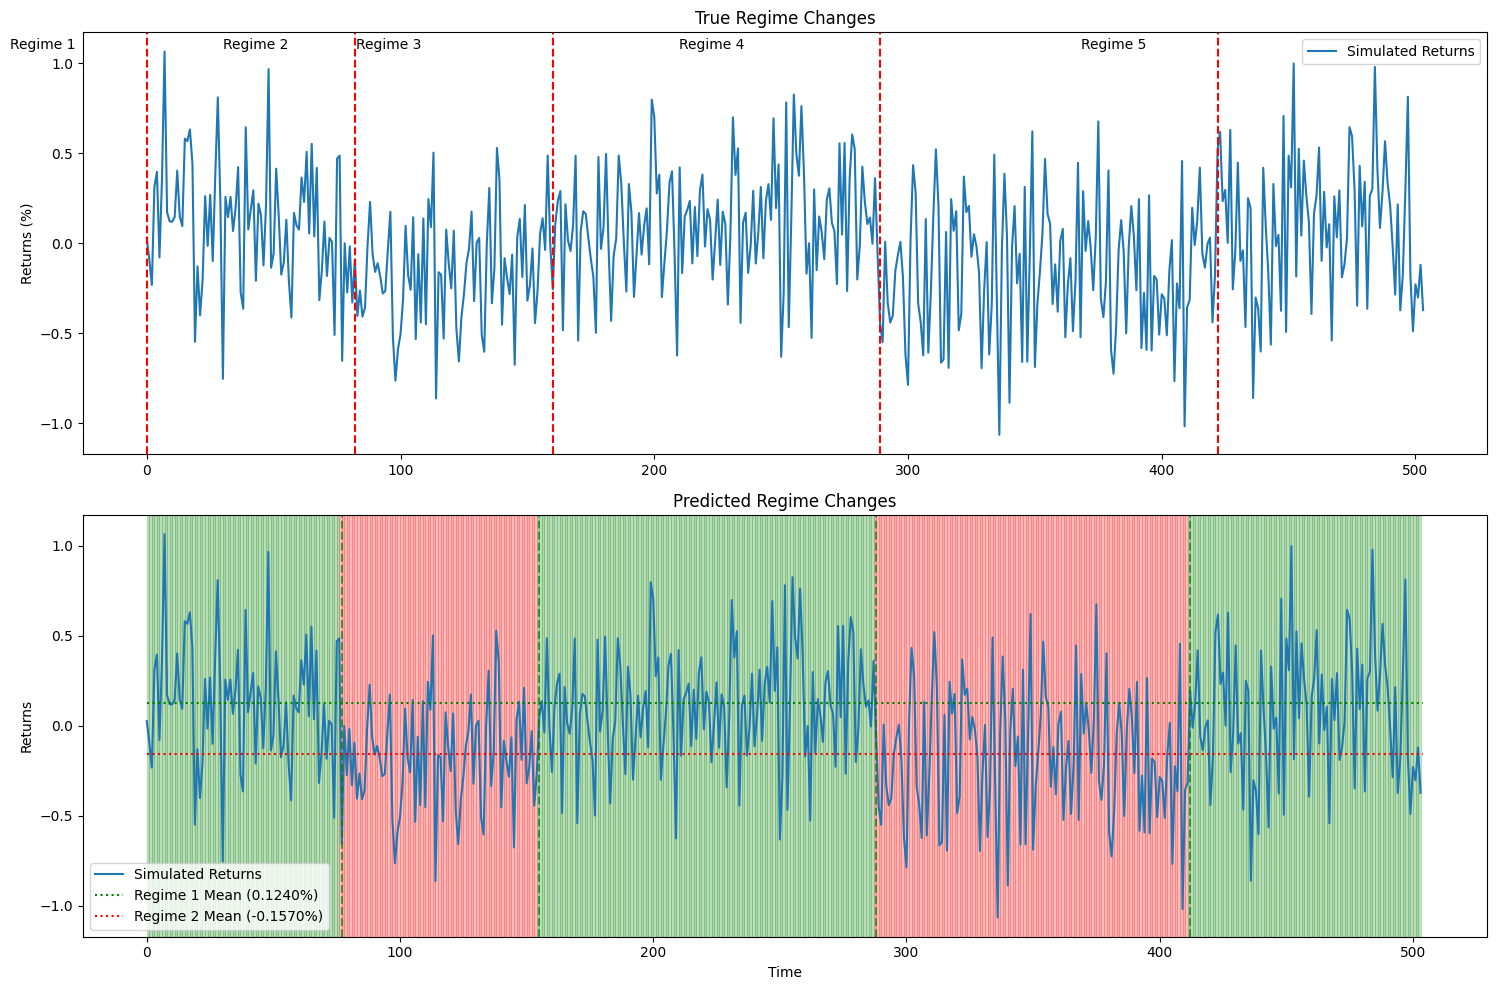

In [60]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: True Regime Changes
ax1.plot(sim_data, label='Simulated Returns')
day = 0
for i in range(len(days)):
    ax1.axvline(x=day, color='red', linestyle='--')
    ax1.text(day - days[i]/2, max(sim_data), f'Regime {i+1}', 
             horizontalalignment='center', verticalalignment='bottom')
    day += days[i]
ax1.set_title('True Regime Changes')
ax1.set_ylabel('Returns (%)')
ax1.legend()

# Plot 2: Predicted Regime Changes
ax2.plot(sim_data, label='Simulated Returns')

# Determine which state is bullish (higher mean)
bullish_state = np.argmax(model.means_)
bearish_state = 1 - bullish_state

# Add colored background for regimes
for i in range(1, len(hidden_states)):
    if hidden_states[i] != hidden_states[i-1]:
        ax2.axvline(x=i, color='green', linestyle='--', alpha=0.7)
    
    # Add colored background
    if hidden_states[i] == bullish_state:
        ax2.axvspan(i-1, i, color='green', alpha=0.2)
    else:
        ax2.axvspan(i-1, i, color='red', alpha=0.2)

# Plot estimated means for each regime
for state in range(n_states):
    mean_value = model.means_[state, 0]
    color = 'green' if state == bullish_state else 'red'
    ax2.hlines(mean_value, 0, len(sim_data), 
               colors=color, 
               linestyles='dotted', 
               label=f'Regime {state+1} Mean ({mean_value:.4f}%)')

ax2.set_title('Predicted Regime Changes')
ax2.set_xlabel('Time')
ax2.set_ylabel('Returns')
ax2.legend()

plt.tight_layout()
plt.show()

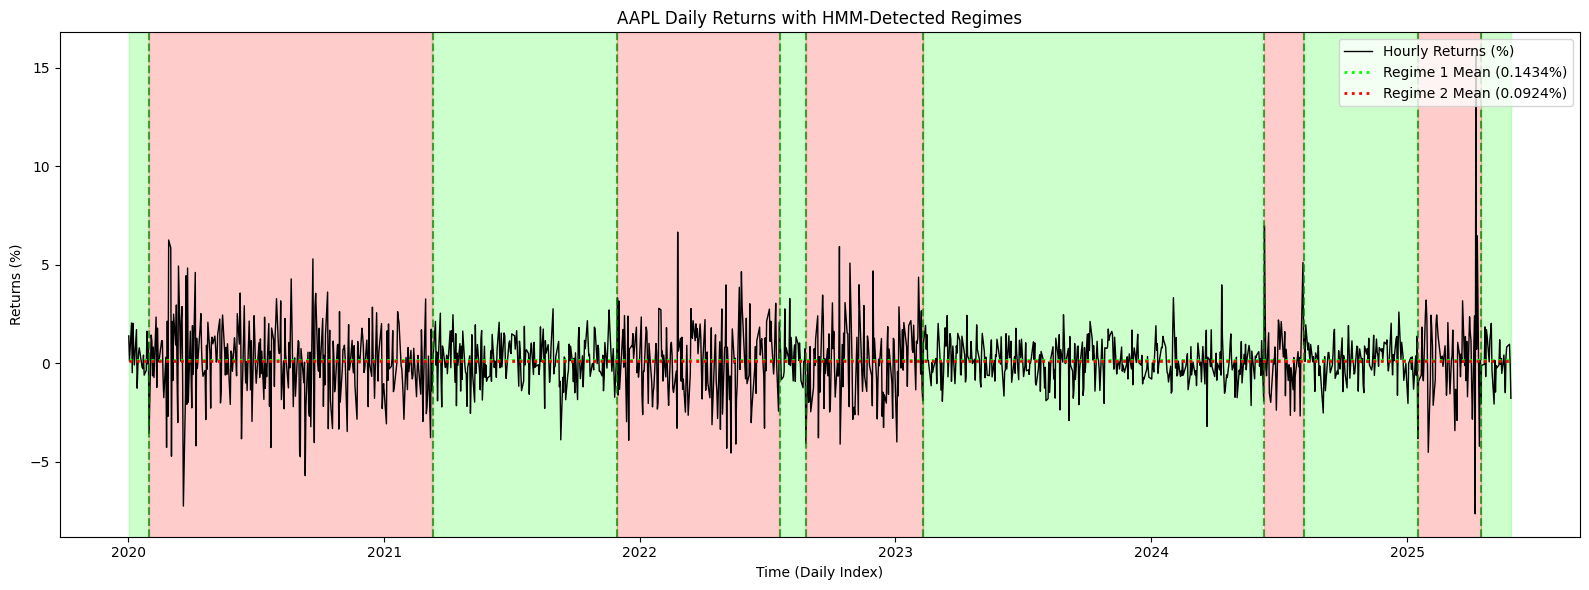

Estimated means of regimes:
Regime 1: 0.14342%
Regime 2: 0.09240%


In [62]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

# Download hourly data for AAPL
ticker = 'AAPL'
df = yf.download(ticker, start='2020-01-01', end='2025-05-30', progress=False)
df.reset_index(inplace=True)

# Calculate percentage returns based on Open and Close prices
df['Percent Change'] = (df['Close'] - df['Open']) * 100 / df['Open']
X = df['Percent Change'].values.reshape(-1, 1)

# Fit HMM
n_states = 2
model = hmm.GaussianHMM(n_components=n_states, covariance_type='diag', n_iter=5000, random_state=42)
model.fit(X)

# Predict hidden states
hidden_states = model.predict(X)
df['State'] = hidden_states

# Colors for regimes
colors = ['#00ff00', '#ff0000']  # Green for bullish and Red for bearish
plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['Percent Change'], color='black', lw=1, label='Hourly Returns (%)')

# Shade background by predicted regimes
for state in range(n_states):
    idx = np.where(df['State'] == state)[0]
    if len(idx) > 0:
        groups = np.split(idx, np.where(np.diff(idx) != 1)[0] + 1)
        for g in groups:
            plt.axvspan(df['Date'].iloc[g[0]], df['Date'].iloc[g[-1]], color=colors[state], alpha=0.2)

# Plot vertical lines at regime change points
for i in range(1, len(df['State'])):
    if df['State'].iloc[i] != df['State'].iloc[i-1]:
        plt.axvline(x=df['Date'].iloc[i], color='green', linestyle='--', alpha=0.7)

# Plot estimated regime means
for state in range(n_states):
    mean_val = model.means_[state, 0]
    plt.hlines(mean_val, df['Date'].iloc[0], df['Date'].iloc[-1], colors=colors[state], linestyles='dotted',
               linewidth=2, label=f'Regime {state+1} Mean ({mean_val:.4f}%)')

plt.title('AAPL Daily Returns with HMM-Detected Regimes')
plt.xlabel('Time (Daily Index)')
plt.ylabel('Returns (%)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Print estimated means
print("Estimated means of regimes:")
for i, mean in enumerate(model.means_.flatten()):
    print(f"Regime {i+1}: {mean:.5f}%")
